# Machine learning & Reinforcement learning for drone

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - Bayes Nets, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name: Zhanchao Yang**

--- 



Choose problem 1 and fill out in this notebook

In [119]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors

#ADD
import math
import random
import numpy



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part B, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [128]:
# Your code here.
class MDPLanding:
    # first need the size of space, reward and discount are need so that share same class with part F
    def __init__(self,L, default_reward,terminal_reward,landing_reward,discount):
        #N increments by 1 to ingore seg fault
        N=L+1
        self.default_reward=default_reward
        self.discount=discount
        self.states=[]
        self.terminal_states={}
        #build our x,y,z space, append each position in the end
        for x in range(N):
            for y in range(N):
                for z in range(N):
        #All of the states with  z=0  are terminal states with -1
                    if z==0:
                        self.terminal_states[(x,y,0)]= terminal_reward
                        self.states.append((x,y,z))
                    else:
                        self.states.append((x,y,z))
        # The center is landing pad, update it reward from -1 to 1
        self.terminal_states[(L/2,L/2,0)]=landing_reward
        
    def actions(self,state):
        moves=[]
        #6 possible actions with x,y,z. And use UDNSEW only help us build the action_list, we don't need to call them
        #all_actions is temp list
        U=(state[0],state[1],state[2]+1)
        D=(state[0],state[1],state[2]-1)
        N=(state[0],state[1]+1,state[2])
        S=(state[0],state[1]-1,state[2])
        E=(state[0]+1,state[1],state[2])
        W=(state[0]-1,state[1],state[2])
        
        all_actions=[U,D,N,S,E,W]
        #if terminal_states, stop
        if state in self.terminal_states:
            return [None]
        else:
        #otherwise list all possibole actions, append to move, and return
            for i in range(len(all_actions)):
                if(all_actions[i] in self.states):
                    moves.append(all_actions[i] )
        return moves
                    
    def reward(self,state):
        #reward have 1,-1,-0.01
        #return -1/1 if terminal,we define it on init
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
     # we can direct call them with init 
            return self.default_reward

    #only for start and next have 1 distance length, only need in policy_iter func
    #return direction according to start and action
    def result(self,state,action):
        #a dictionary for possibole moves
        lst_move={(0,0,1):'U',(0,0,-1):'D', (0,1,0):'N',(0,-1,0):'S',(1,0,0):'E',(-1,0,0):'W'}
        
        move=( action[0] -state[0],action[1] -state[1] ,action[2] -state[2] )
        #use get method to get value given key
        return (  lst_move.get(move) )
        

In [129]:
#unit test
L=2
a=MDPLanding(L,default_reward=-0.01,terminal_reward=-1,landing_reward=1,discount=0.999 )

#test 1 check terminal_states and state if level 2
print('test1:',a.terminal_states) 
print('test1:',a.states) 
#test 2
#check possiable move for given state, should return 6 moves
out1=a.actions((1,1,1))
print('test2:',out1)

#test 3 answer expect be N , if we start from (1,0,0) and end (1,1,0)
out2=a.result((1,0,0),(1,1,0))
print('test3:', out2)

test1: {(0, 0, 0): -1, (0, 1, 0): -1, (0, 2, 0): -1, (1, 0, 0): -1, (1, 1, 0): 1, (1, 2, 0): -1, (2, 0, 0): -1, (2, 1, 0): -1, (2, 2, 0): -1}
test1: [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
test2: [(1, 1, 2), (1, 1, 0), (1, 2, 1), (1, 0, 1), (2, 1, 1), (0, 1, 1)]
test3: N


#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [130]:
# Your code here.
#https://www.adamsmith.haus/python/answers/how-to-find-the-index-of-the-max-value-in-a-list-in-python
# use for how to find the max value given index
# use lecture 33 note 
import copy
def policy_iteration(MDP,s):
#initlize  default_ult/ U(s) =0
    default_ult={}
    update_ult={}
    for state in MDP.states:
        default_ult[state]=0
    Done=True
    n=0
    #set up a while loop, iteration from n=0
    while Done :
        for state in MDP.states:
    # terminal_states have -1/1,direct append them
            if state in MDP.terminal_states:
                update_ult[state]=MDP.reward(state)
            else:
    #action_ult is all possbile Utility for next action, default_reward is R(s)
                action_ult=[ default_ult[state] for state in MDP.actions(state)]
                default_reward=MDP.reward(state)
    #function is same as lecture note
                update_ult[state]=default_reward+MDP.discount * max(action_ult)
    #copy to default_ult then keep update new list, idea is do iterion,
        n+=1
        default_ult=copy.deepcopy(update_ult)
    # here I choose  do 20 iteration then stop
        if (n==20):
            Done = False
            
    #first part we will have update_ult, second part find the policy given states
    print('start',s)
    #create a direction_lst
    lst_0=[]
    while s not in MDP.terminal_states:
        #S to store old s value
        S=s
        #lst is the action list
        lst=MDP.actions(s)
        #lst2 is the utility list
        lst2=[update_ult[x] for x in MDP.actions(s)]
        max_value=max(lst2)
        #get index of state with max utility
        max_index=lst2.index(max_value)
        #get the correpond state with max utility
        s=lst[max_index]
        # append to irection_lst
        lst_0.append( MDP.result(S,s))
        print(s)    
    print('direction is: ',lst_0)


L=4
MDP= MDPLanding(L,default_reward=-0.01,terminal_reward=-1,landing_reward=1,discount=0.999)

print('the policy for (2,2,1) is:')
out1 = policy_iteration(MDP,(2,2,1))
print('--')

print('the policy for (0,2,1) is:')
out2 = policy_iteration(MDP,(0,2,1))
print('--')

print('the policy for (2,0,1) is:')
out3 = policy_iteration(MDP,(2,0,1))

the policy for (2,2,1) is:
start (2, 2, 1)
(2, 2, 0)
direction is:  ['D']
--
the policy for (0,2,1) is:
start (0, 2, 1)
(1, 2, 1)
(2, 2, 1)
(2, 2, 0)
direction is:  ['E', 'E', 'D']
--
the policy for (2,0,1) is:
start (2, 0, 1)
(2, 1, 1)
(2, 2, 1)
(2, 2, 0)
direction is:  ['N', 'N', 'D']


#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [136]:
# Your code here.
#use lecture 35 note 

#input is learning rate, number of training episodes
def Q_learning(MDP,lr, n_it):
# create two new lists for terminal/state given MDP, copy them
    spaces=[]
    terminal=[]
    spaces=copy.deepcopy(MDP.states)
    terminal=copy.deepcopy(MDP.terminal_states)
    Q= {}
    R= {}
    #n is steps and creat list which value_lst for cumulative reward
    n = 0
    value_lst = []  
    
   #initlize Q table as 0 and reward_table with s,a
    for s in spaces:
        a_lst = MDP.actions(s)
        for a in a_lst:
        # if not reach terminal state next, use reward of next state 
            R[(s,a)] = MDP.reward(a)
            Q[(s,a)] = 0
            if(a in terminal):
        # if reach terminal state next, use reward of current state 
                R[(a,s)]=MDP.reward(s)
                Q[(a,s)]=0
    # v is value for cumulative reward, loop with training episodes
    v=0
    for i in range(n_it):
    # random start, choose any MDP state, choose again if terminal state
        s=random.choice(spaces)
        while s in terminal:
            s=random.choice(spaces)
        # if terminal state, not count value and the step
        v=0   
        while s not in terminal:
            a = random.choice(MDP.actions(s))
#             adjQ = [ Q[(a, next_a)] for next_a in MDP.actions(a) ]
# function is similar as lecture, Q= Q+lr*(R + gamma * max adjQ), adjQ is Qtable for next action
            Q[(s, a)] =0+ lr*(R[(s, a)] + MDP.discount *max( [ Q[(a, next_a)] for next_a in MDP.actions(a) ])  )
# add to cumulative reward then set state equal to next state, do iteration
            v+= Q[(s, a)] 
            s = a
            n += 1
    #if we reach termianl state then return, otherwise reach 50 limit steps to stop
            if(n==50):
                break
        #get the average value and add to value list 
        value_per_step=v/n
        value_lst.append(value_per_step)
    # if not terminal state, we want count vvalue and the step
        n = 0
# as requirement, return Q table and value as array for part d
    return (Q, value_lst)
             

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

increase from about -0.5041744495262805
mean of last 5000 trial is 0.7884684296649178


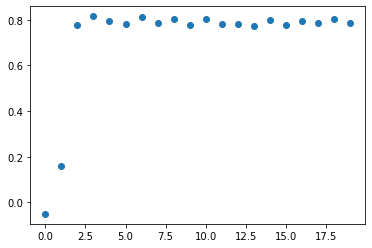

In [137]:
# Your code here.
#use np.array to build array https://numpy.org/doc/stable/reference/generated/numpy.array.html
#split array: https://kanoki.org/2020/06/11/how-to-split-numpy-arrays/
# use mean with axis https://numpy.org/doc/stable/reference/generated/numpy.mean.html

# set up all the input var, use lr as large and at least 10000 trials
L=10
lr=0.9999
trial=10000

#Use blocks of 500 training trials.
block = trial/500

MDP1 = MDPLanding(L,default_reward=-0.01,terminal_reward=-1,landing_reward=1,discount=0.999)
(out_1, out2) = Q_learning(MDP1, lr,trial)

#value list is array ,treat out2 as array
#find first element
print('increase from about',np.mean(numpy.array(out2[ 0:500]))* L )

print( 'mean of last 5000 trial is' ,np.mean(numpy.array(out2[ 5000: 10000])  )  )

#splict function to get 20 blocks and find y-axis value then calc last 5000 trials average,
y= np.mean(np.split(numpy.array(out2),block),  axis=1)

#assign x 0 to 19
x=[]
for i in range(len(y)):
    x.append(i)
#plt.plot(x, means) will plot as line
#use scatter to plot point that is better
plt.scatter(x, y)
plt.show()

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

$\textbf{answer:}$

1.Because at the beginning, our drone only cares about short-term benefits, it only wants to reach the terminal state, and doesn't care that it is -1/1, and in probability theory，most of the terminal state drone will take is -1, so drone will take many steps to reach -1, and the next time drone will take less steps to reach -1. And 0.5 is the difference in the number of steps spent. In this case, cumulative reward will not start from a number greater than 0 but start off around -0.5 (see first dot in the graph part d).

2.Because we want the drone to learn, a large learning rate makes it value long-term benefits, and the drone will target the terminal state of 1, so the value is positive. Due to the use of random start, drone may take a relatively small number of steps to reach 1 each time, plus there is a dicount factor each time, so 0.8 is the largest possible reward from random to landing. Limited by a fixed discount 0.999, a learning rate and the necessary number of steps to landing, discount  value makes continuous rewards less and less, so cannot get a reward much larger than 0.8 (see the last few dots of part d).

#### Part F
Choose three other reward structures, including the terminal rewards and the living rewards, and rerun your policy iteration and Q-learning algorithms with those reward structures. Write a paragraph or two describing the reward structures that you selected, what impact you expected the changes to have on your results, and what changes actually happened. If there was a difference in what you expected and what actually happened, reflect on why there was a difference. 

In [133]:
#all 3 structures use different terminal_reward=-0.8 landing_reward=0.8
#reward structure 1 
#large default_reward, less dicount, same lr
L=4
s=(0,2,1)
MDP2 = MDPLanding(L,default_reward=-0.001,terminal_reward=-0.8,landing_reward=0.8,discount=0.99)
policy_iteration(MDP2, s)
(out1,out2)= Q_learning(MDP2 ,lr=0.9999, n_it=10000)
print( 'mean of last 5000 trial of structure 1 is:' ,np.mean(numpy.array(out2[ 5000: 10000])  )  )



start (0, 2, 1)
(1, 2, 1)
(2, 2, 1)
(2, 2, 0)
direction is:  ['E', 'E', 'D']
mean of last 5000 trial of structure 1 is: 0.576950281835016


In [134]:
#reward structure 2
#less default_reward, less dicount, same lr
MDP2 = MDPLanding(L,default_reward=-0.1,terminal_reward=-0.8,landing_reward=0.8,discount=0.99)
policy_iteration(MDP2, s)
(out1,out2)= Q_learning(MDP2 ,lr=0.9999, n_it=10000)
print( 'mean of last 5000 trial of structure 2 is:' ,np.mean(numpy.array(out2[ 5000: 10000])  )  )


start (0, 2, 1)
(1, 2, 1)
(2, 2, 1)
(2, 2, 0)
direction is:  ['E', 'E', 'D']
mean of last 5000 trial of structure 2 is: 0.16309728816471217


In [135]:
#reward structure 3
#less default_reward, less dicount, less lr
MDP2 = MDPLanding(L,default_reward=-0.1,terminal_reward=-0.8,landing_reward=0.8,discount=0.99)
policy_iteration(MDP2, s)
(out1,out2)= Q_learning(MDP2 ,lr=0.99, n_it=10000)
print( 'mean of last 5000 trial of structure 3 is:' ,np.mean(numpy.array(out2[ 5000: 10000])  )  )

start (0, 2, 1)
(1, 2, 1)
(2, 2, 1)
(2, 2, 0)
direction is:  ['E', 'E', 'D']
mean of last 5000 trial of structure 3 is: 0.14372857703463301


$\textbf{answer:}$
First of all, the three rewards are different from the terminal and living reward of the previous rewards, so I increased the terminal value and decreased the landing value. $\textbf{The first reward structure}$ is large default_reward, less dicount, same learning rate; $\textbf{the second reward structure}$ is less default_reward, less dicount, same learning rate; $\textbf{the third reward structure}$ is less default_reward, less dicount, less learning rate.

I think that compared with the previous structure, the rewards of the new three structures will decrease. $\textbf{My expectation}$ is that for Qlearning, among the three rewards, structure 1 $>$ structure 2 $>$ structure 3, and for policy iteration, the three reward structures are finally reach the landing state and the steps are the same. $\textbf{The actual result}$ is as I expected. $\textbf{The explanation}$ is that because drone pursues long-term interests, it pursues a state of +0.8, so under policy iteartion, the strategies of the three reward structures are the same, and these three utility decreases due to the decrease in landing interests. The difference between reward structures 1 and 2 is the default reward, because structure 1 has a larger value, so the cost of its steps is less, resulting in the average benefit of reward structure 1 $>$ structure 2; the difference between reward structures 2 and 3 is learning rate, because structure 2 has more A large learning rate, which tends to continuously learn to gain and update a larger utility, results in a reward structure 2 with an average benefit $>$ structure3.